In [157]:
import pandas as pd
from subprocess import call
from os.path import split, basename
from os import listdir
from tempfile import NamedTemporaryFile
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
plt.rcParams['figure.figsize'] = (10, 10)

# Process Datafile

In [30]:
DATAFILE = "../data/jan1981To.csv"
data = pd.read_csv(DATAFILE, parse_dates=['datetimef']).set_index('datetimef')

In [169]:
def pointsToGrid(data, x, y, z, outfile, xsize=100, ysize=100):
    _VRT = """
        <OGRVRTDataSource>
            <OGRVRTLayer name={name}>
                <SrcDataSource>{loc}</SrcDataSource>
                <GeometryType>wkbPoint</GeometryType>
                <GeometryField encoding="PointFromColumns" x={x} y={y} z={z}/>
            </OGRVRTLayer>
        </OGRVRTDataSource>
    """
    with NamedTemporaryFile('w', suffix = '.csv') as tmpf:
        # save csv
        tmpdir, tmpfname = split(tmpf.name)
        data.loc['1981-01-01 12:00'][[x, y, z]].to_csv(tmpf)
        tmpf.flush()
        
        # create vrt
        vrtTmp = NamedTemporaryFile('w', dir=tmpdir, delete=False)
        vrt = _VRT.format(loc = tmpf.name,
                          name=tmpfname.split(".")[0], 
                          x = x, y = y, z = z)
        vrtTmp.write(vrt)
        vrtTmp.flush()
    
        # grid data
        call(["gdal_grid", vrtTmp.name, outfile, "-outsize", str(xsize), str(ysize), 
              "-a", "invdistnn:radius=30"])
        vrtTmp.close()
    







In [170]:
pointsToGrid(data.loc["1981-01-01 12:00"], 'lon', 'lat', 'To_Lizard', outfile='testout123.tif', xsize=500, ysize=500)

In [171]:
import rasterio
from rasterio.plot import show


/Users/tony/miniconda3/envs/imageprocess/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2862: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  exec(code_obj, self.user_global_ns, self.user_ns)


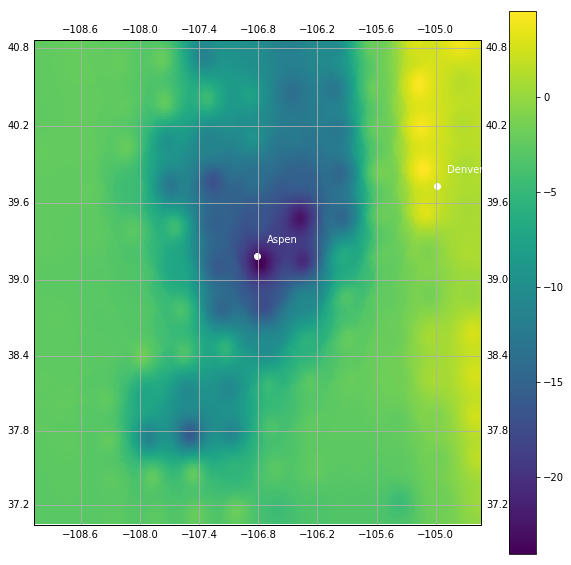

In [184]:
filename = 'testout123.tif'

with rasterio.open(filename, 'r') as src:

        bounds = src.bounds
        # read image into ndarray
        im = src.read()

        # transpose the array from (band, row, col) to (row, col, band)
        im = np.transpose(im, [1,2,0])
        im = im.squeeze()
        # calculate extent of raster
        xmin = src.transform[0]
        xmax = src.transform[0] + src.transform[1]*src.width
        ymin = src.transform[3] + src.transform[5]*src.height
        ymax = src.transform[3]

        # define cartopy crs for the raster, based on rasterio metadata
        crs = ccrs.PlateCarree()

        # create figure
        ax = plt.axes(projection=ccrs.Mercator().GOOGLE)
        ax.set_extent([bounds.left, bounds.right, bounds.bottom, bounds.top])
        ax.set_xmargin(0.05)
        ax.set_ymargin(0.10)

        # plot raster
        plt.imshow(im, origin='upper', extent=[xmin, xmax, ymin, ymax], transform=crs, interpolation='nearest')

    
        # plot coastlines
        ax.gridlines(draw_labels=True)
        plt.colorbar()

        
        reflat_a, reflon_a = 39.1911, -106.8175
        reflat_b, reflon_b = 39.7392, -104.9903
        ax.text(reflon_a+.1, reflat_a+.1, 'Aspen', transform=crs, color='white')
        ax.text(reflon_b+.1, reflat_b+.1, "Denver", transform=crs, color='white')
        ax.scatter(reflon_a, reflat_a, color='white', marker='o', transform=crs)
        ax.scatter(reflon_b, reflat_b, color='white', marker='o', transform=crs)
        plt.savefig('testfigure.png')
        plt.show()


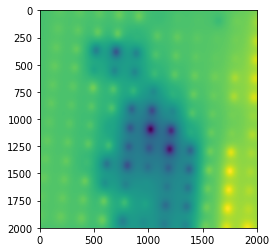

In [36]:
show(rast)